In [1]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



In [71]:
DATA_DIR = os.path.join('.', 'data')
IMAGE_DIR = os.path.join('.', 'data\\HAM10000_images\\')


lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [24]:
reverse_label_mapping

{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}

In [25]:
data = pd.read_csv(os.path.join(DATA_DIR,'HAM10000_metadata.csv'))


In [29]:
data.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [28]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,male,back
freq,6,1,6705,5340,5406,2192


In [37]:
data.isnull().value_counts()

lesion_id  image_id  dx     dx_type  age    sex    localization
False      False     False  False    False  False  False           9958
                                     True   False  False             57
dtype: int64

In [38]:
# Handling age null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype to int32
data['age'] = data['age'].astype('int32')

In [72]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = IMAGE_DIR + data['image_id'] + ".JPG"

In [73]:
data

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),.\data\HAM10000_images\ISIC_0027419.JPG
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),.\data\HAM10000_images\ISIC_0025030.JPG
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),.\data\HAM10000_images\ISIC_0026769.JPG
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),.\data\HAM10000_images\ISIC_0025661.JPG
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),.\data\HAM10000_images\ISIC_0031633.JPG
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40,male,abdomen,Actinic keratoses (akiec),.\data\HAM10000_images\ISIC_0033084.JPG
10011,HAM_0002867,ISIC_0033550,akiec,histo,40,male,abdomen,Actinic keratoses (akiec),.\data\HAM10000_images\ISIC_0033550.JPG
10012,HAM_0002867,ISIC_0033536,akiec,histo,40,male,abdomen,Actinic keratoses (akiec),.\data\HAM10000_images\ISIC_0033536.JPG
10013,HAM_0000239,ISIC_0032854,akiec,histo,80,male,face,Actinic keratoses (akiec),.\data\HAM10000_images\ISIC_0032854.JPG


In [74]:
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [75]:
data

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),.\data\HAM10000_images\ISIC_0027419.JPG,"[[[192, 153, 193], [195, 155, 192], [197, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),.\data\HAM10000_images\ISIC_0025030.JPG,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),.\data\HAM10000_images\ISIC_0026769.JPG,"[[[192, 138, 153], [200, 144, 162], [202, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),.\data\HAM10000_images\ISIC_0025661.JPG,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),.\data\HAM10000_images\ISIC_0031633.JPG,"[[[159, 114, 140], [194, 144, 173], [215, 162,..."
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40,male,abdomen,Actinic keratoses (akiec),.\data\HAM10000_images\ISIC_0033084.JPG,"[[[183, 166, 182], [183, 165, 181], [184, 167,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40,male,abdomen,Actinic keratoses (akiec),.\data\HAM10000_images\ISIC_0033550.JPG,"[[[3, 4, 2], [41, 36, 35], [119, 103, 102], [1..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40,male,abdomen,Actinic keratoses (akiec),.\data\HAM10000_images\ISIC_0033536.JPG,"[[[134, 120, 120], [166, 148, 149], [175, 155,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80,male,face,Actinic keratoses (akiec),.\data\HAM10000_images\ISIC_0032854.JPG,"[[[160, 124, 146], [164, 131, 151], [166, 127,..."


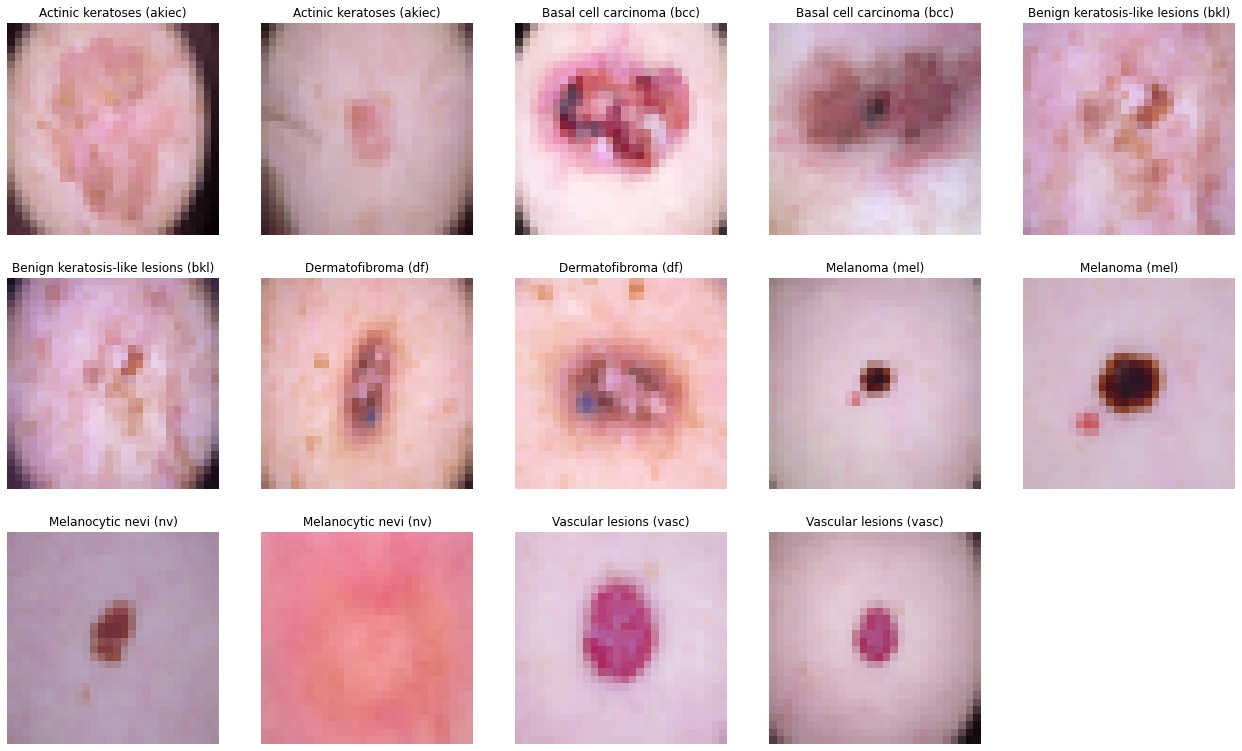

In [76]:
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [77]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [78]:
data.head(5)

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
0,5007,HAM_0006322,ISIC_0030309,nv,follow_up,55,male,foot,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0030309.JPG,"[[[237, 159, 171], [238, 158, 173], [241, 161,...",0
1,4478,HAM_0003084,ISIC_0026191,nv,follow_up,45,female,upper extremity,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0026191.JPG,"[[[219, 112, 131], [223, 119, 136], [224, 121,...",0
2,4477,HAM_0002093,ISIC_0027032,nv,follow_up,45,female,back,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0027032.JPG,"[[[234, 134, 155], [238, 140, 164], [234, 130,...",0
3,4476,HAM_0003701,ISIC_0027191,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0027191.JPG,"[[[214, 121, 154], [216, 124, 159], [218, 124,...",0
4,4475,HAM_0003806,ISIC_0028667,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0028667.JPG,"[[[234, 146, 167], [236, 149, 171], [233, 149,...",0


In [94]:
# make the same size samples 
data['label'].value_counts()

0    6705
1    1113
2    1099
3     514
4     327
5     142
6     115
Name: label, dtype: int64

In [79]:
# 0	6705			
# 1	1113	4	4452	6678
# 2	1099	4	4396	6594
# 3	514	   11	5654	6682
# 4	327	   17	5559	6213
# 5	142	   45	6390	6674
# 6	115	   52	5980	6210

_label = 0
groups = [data]
for i in [4,4,11,17,45,52]:
    _label+=1
    index = data[data['label'] == _label].index.values
    df_l = data.iloc[int(min(index)):int(max(index)+1)]
    df_l = df_l.append([df_l]*i, ignore_index = True)
    groups.append(df_l)

C:\Users\bakig\AppData\Local\Temp\ipykernel_23920\1719705814.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_index = df_index.append([df_index]*i, ignore_index = True)


In [86]:
final_data = pd.concat(groups)

In [95]:
final_data['label'].value_counts()

0    6705
3    6682
1    6678
5    6674
2    6594
4    6213
6    6210
Name: label, dtype: int64

In [96]:
final_data.head(5)

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
0,5007,HAM_0006322,ISIC_0030309,nv,follow_up,55,male,foot,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0030309.JPG,"[[[237, 159, 171], [238, 158, 173], [241, 161,...",0
1,4478,HAM_0003084,ISIC_0026191,nv,follow_up,45,female,upper extremity,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0026191.JPG,"[[[219, 112, 131], [223, 119, 136], [224, 121,...",0
2,4477,HAM_0002093,ISIC_0027032,nv,follow_up,45,female,back,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0027032.JPG,"[[[234, 134, 155], [238, 140, 164], [234, 130,...",0
3,4476,HAM_0003701,ISIC_0027191,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0027191.JPG,"[[[214, 121, 154], [216, 124, 159], [218, 124,...",0
4,4475,HAM_0003806,ISIC_0028667,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0028667.JPG,"[[[234, 146, 167], [236, 149, 171], [233, 149,...",0


In [118]:
data.to_csv("dataall.csv")

In [119]:
final_data.to_csv("final_aug.csv")

In [97]:
# ORIGINAL
# Convert image pixel columnm into numpy array
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [98]:
# AUGMENTED DATA
# Convert image pixel columnm into numpy array
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


In [99]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

In [100]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model

In [101]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto')
                               #, restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

In [120]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

In [103]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('_confusion_matrix.png', dpi=300)

In [105]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [106]:
model =create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [107]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [108]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 50)

Epoch 1/50
458/458 [==============================] - 10s 11ms/step - loss: 1.5082 - accuracy: 0.4909 - val_loss: 1.0346 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 2/50
458/458 [==============================] - 4s 10ms/step - loss: 0.7661 - accuracy: 0.7123 - val_loss: 0.6726 - val_accuracy: 0.7364 - lr: 0.0010
Epoch 3/50
458/458 [==============================] - 4s 9ms/step - loss: 0.5615 - accuracy: 0.7874 - val_loss: 0.4560 - val_accuracy: 0.8360 - lr: 0.0010
Epoch 4/50
458/458 [==============================] - 4s 9ms/step - loss: 0.4080 - accuracy: 0.8498 - val_loss: 0.3773 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 5/50
458/458 [==============================] - 4s 10ms/step - loss: 0.3314 - accuracy: 0.8780 - val_loss: 0.3077 - val_accuracy: 0.8918 - lr: 0.0010
Epoch 6/50
458/458 [==============================] - 4s 10ms/step - loss: 0.2480 - accuracy: 0.9104 - val_loss: 0.2674 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 7/50
458/458 [==============================] - 4s 9ms/step

In [110]:
model.save('Skin_Cancer.sav')

INFO:tensorflow:Assets written to: Skin_Cancer.sav\assets


In [111]:
model.save_weights("Skin_Cancer.hdf5")

In [123]:
# Saving the model for Future Inferences

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

Test Accuracy: 96.905%
              precision    recall  f1-score   support

          nv       1.00      0.96      0.98      1374
         mel       0.86      1.00      0.92       205
         bkl       0.92      1.00      0.96       227
         bcc       0.95      1.00      0.97        94
       akiec       0.98      1.00      0.99        55
        vasc       0.93      1.00      0.97        28
          df       1.00      1.00      1.00        20

    accuracy                           0.97      2003
   macro avg       0.95      0.99      0.97      2003
weighted avg       0.97      0.97      0.97      2003

[[1313   33   20    5    1    2    0]
 [   1  204    0    0    0    0    0]
 [   0    0  227    0    0    0    0]
 [   0    0    0   94    0    0    0]
 [   0    0    0    0   55    0    0]
 [   0    0    0    0    0   28    0]
 [   0    0    0    0    0    0   20]]


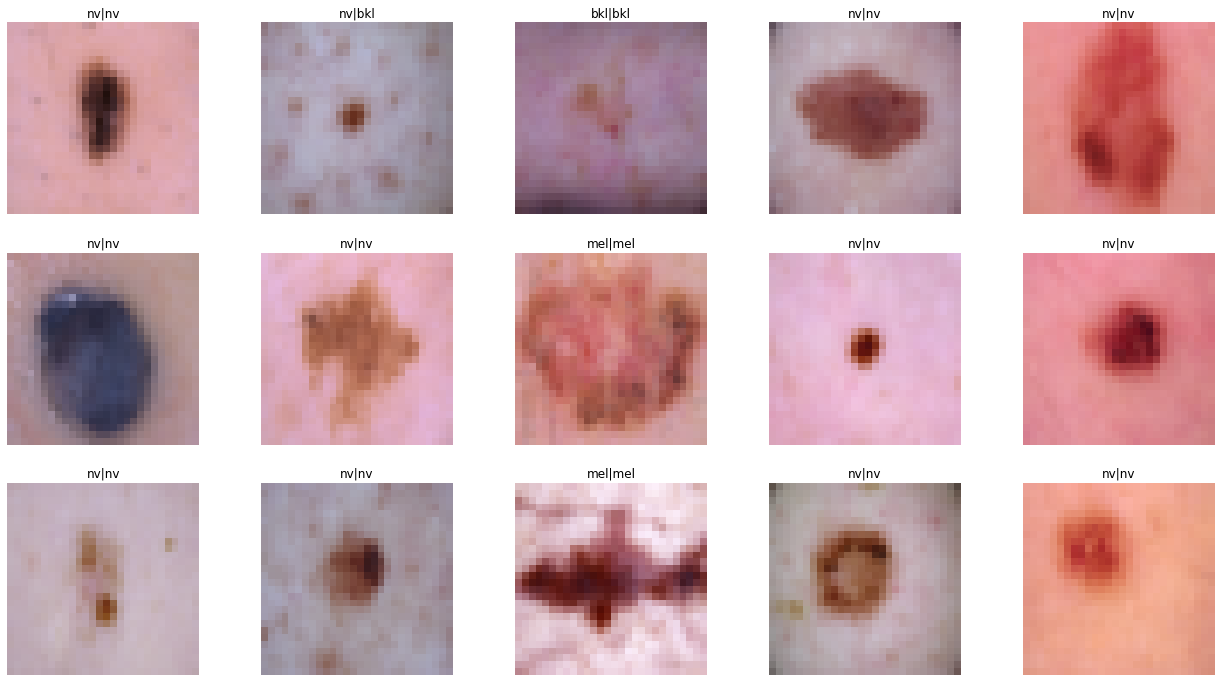

In [121]:
test_model(model, X_test_orig, Y_test_orig)

Test Accuracy: 97.826%
              precision    recall  f1-score   support

          nv       0.99      0.87      0.92      1385
         mel       0.94      0.99      0.96      1328
         bkl       0.94      1.00      0.97      1294
         bcc       0.99      1.00      0.99      1325
       akiec       1.00      1.00      1.00      1270
        vasc       1.00      1.00      1.00      1293
          df       1.00      1.00      1.00      1257

    accuracy                           0.98      9152
   macro avg       0.98      0.98      0.98      9152
weighted avg       0.98      0.98      0.98      9152

[[1203   86   75   15    1    2    3]
 [  10 1315    3    0    0    0    0]
 [   4    0 1290    0    0    0    0]
 [   0    0    0 1325    0    0    0]
 [   0    0    0    0 1270    0    0]
 [   0    0    0    0    0 1293    0]
 [   0    0    0    0    0    0 1257]]


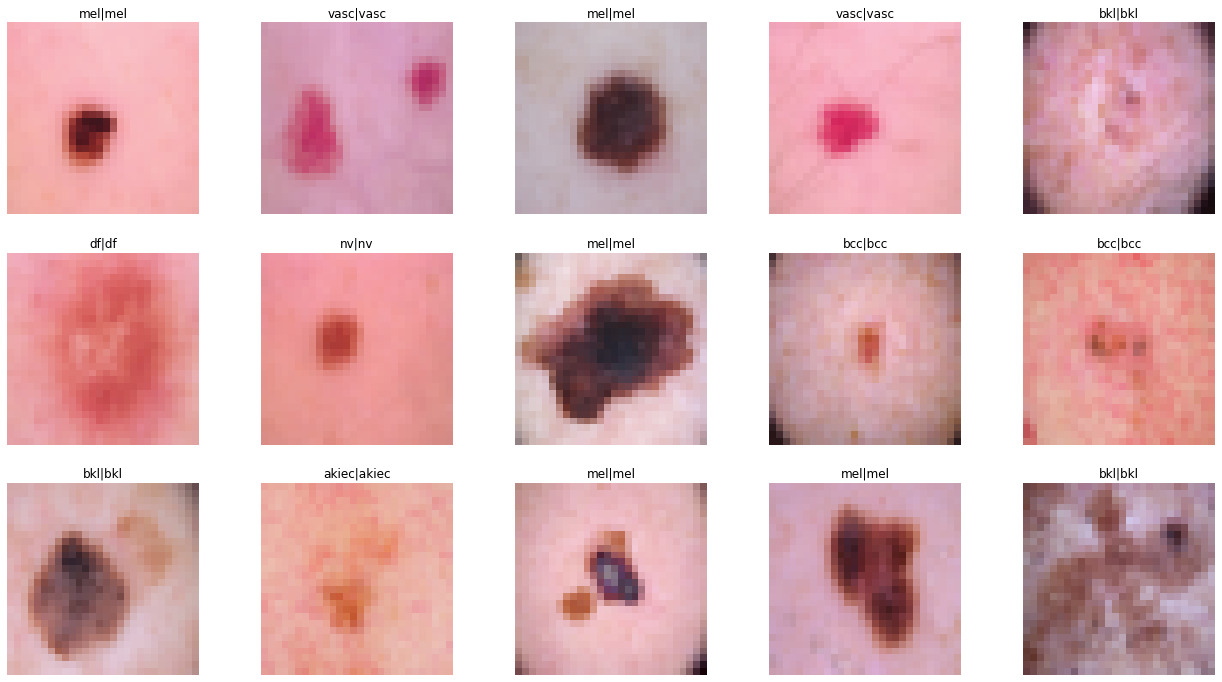

In [122]:
test_model(model, X_test_aug, Y_test_aug)

(28, 28, 3)

In [125]:
data.iloc[2]

index                                                        4477
lesion_id                                             HAM_0002093
image_id                                             ISIC_0027032
dx                                                             nv
dx_type                                                 follow_up
age                                                            45
sex                                                        female
localization                                                 back
cell_type                                   Melanocytic nevi (nv)
path                      .\data\HAM10000_images\ISIC_0027032.JPG
image_pixel     [[[234, 134, 155], [238, 140, 164], [234, 130,...
label                                                           0
Name: 2, dtype: object

In [128]:
one_picture_predict_data.image_pixel.shape

(28, 28, 3)

In [129]:
one_picture_predict_data = data.iloc[2]
print(one_picture_predict_data)
print(one_picture_predict_data.dx)
#print(one_picture_predict_data.image_pixel)
y_value = reverse_label_mapping.get(one_picture_predict_data.dx)
print(y_value)


one_picture_predict_data.image_pixel.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
print(new_one)
model.predict(new_one)

index                                                        4477
lesion_id                                             HAM_0002093
image_id                                             ISIC_0027032
dx                                                             nv
dx_type                                                 follow_up
age                                                            45
sex                                                        female
localization                                                 back
cell_type                                   Melanocytic nevi (nv)
path                      .\data\HAM10000_images\ISIC_0027032.JPG
image_pixel     [[[234, 134, 155], [238, 140, 164], [234, 130,...
label                                                           0
Name: 2, dtype: object
nv
0
[[[[234 134 155]
   [238 140 164]
   [234 130 150]
   ...
   [232 127 149]
   [234 131 156]
   [233 134 156]]

  [[231 130 151]
   [237 137 160]
   [233 126 145]
   ...
   [232 132

array([[1.0000000e+00, 6.3326507e-14, 1.6583433e-08, 1.7311076e-26,
        1.7305985e-27, 1.5154092e-34, 1.9206992e-33]], dtype=float32)

In [126]:
new_one.shape

(1, 28, 28, 3)

In [127]:
print(data.iloc[2].path)
im = np.asarray(Image.open(data.iloc[2].path))
im.shape
im = im.reshape((1,450,600,3))
im.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

.\data\HAM10000_images\ISIC_0027032.JPG


array([[1.0000000e+00, 6.3326507e-14, 1.6583433e-08, 1.7311076e-26,
        1.7305985e-27, 1.5154092e-34, 1.9206992e-33]], dtype=float32)